# Tutorial example

For this example, we'll calculate the distance to the nearest road using a global road raster derived from Open Street Map. Our goal will be to compute this at a 1km resolution in globally in the Molleweide equal-area projection, but we'll approach the analysis in steps.

There are a couple extra dependencies:
- We'll use `mahotas` to compute a fast distance transform.
- We'll also use `shapely` and `geopandas` to preview the geometries of the chunks.

In [1]:
# Install the mahotas library if necessary
#!pip install --quiet mahotas shapely geopandas

import mahotas
import numpy as np
from rasterio.plot import show
from cog_worker import Manager


## Setup
First we'll define our output bounds, scale, and projection using a `cog_worker.Manager`. You'll use the manager to preview or execute the analysis.

In [2]:
manager = Manager(
    proj = "+proj=moll",  # molleweide
    scale = 1000,  # meters
    bounds = (-180, -90, 180, 90)
)

## Writing a Worker function

Next we'll try reading the COG. We write a function that will recieve a `cog_worker.Worker` as its first parameter.
The worker keeps track of the scope of the analysis and provides the `cog_worker.Worker.read()` function that will automatically
reproject and rescale the source data to the output that scope you're tarketing.

We can preview this analysis at a reduced resolution by passing the function to the `cog_worker.Manager.preview()`.
When executing an analysis the Manger will create a `cog_worker.Worker`, and pass it to your fuction.

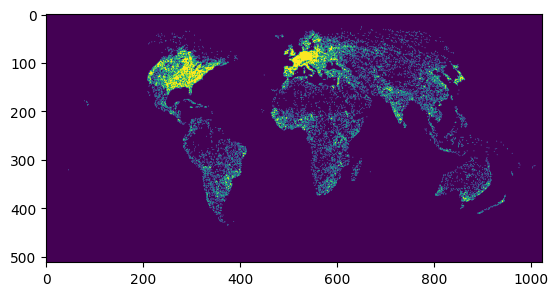

<Axes: >

In [3]:
# Let's check what the roads raster looks like
def get_roads(worker):
    # use the worker to read the COG, reprojecting and resampling as necessary
    roads = worker.read('roads_cog.tif')
    return roads

# Preview the analysis at a reduced scale
arr, bbox = manager.preview(get_roads, max_size=1024)
show(arr)

Let's add some analysis. `worker.read` returns a Numpy masked array so we can use many different libraries to operate on it.

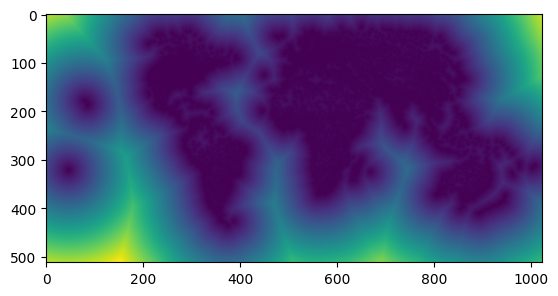

<Axes: >

In [4]:
# Run a fast squared euclidian distance transform on the roads raster

def get_roads_dist(worker):
    roads = worker.read('roads_cog.tif')
    
    # compute squared distance from zeroed pixels
    dist_2 = mahotas.distance(roads != 1)

    # take the square-root to get euclidian distance
    dist = np.sqrt(dist_2)
    
    return dist

arr, bbox = manager.preview(get_roads_dist)
show(arr)


Next since we want to compute actual distance, we should multiple the result of the distance function,
which measures pixels, by the current scale of the analysis.

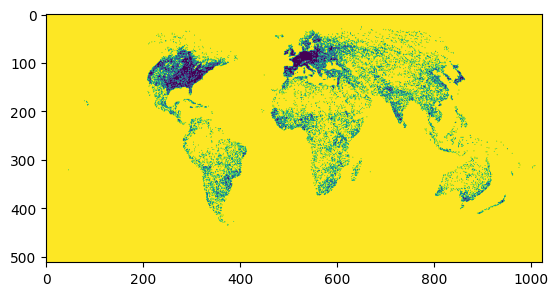

<Axes: >

In [5]:
# Change from computing distance in pixels to meters,
# as the scale of pixels depends on if we're just previwing the image or running the full analysis.
def get_roads_dist_meters(worker):
    roads = worker.read('roads_cog.tif')
    dist_2 = mahotas.distance(roads != 1)
    dist = np.sqrt(dist_2)
    
    # convert from pixels to meters
    dist_meters = dist * worker.scale

    # truncate the results so that values above 10km get set to 10km
    dist_clip = np.clip(dist_meters, 0, 10000)

    return dist_clip

arr, bbox = manager.preview(get_roads_dist_meters)
show(arr)

## Previewing analysis
You can try zooming in or modifying the parameters in other ways. The `preview` function will change the scale to fit within 1024x1024px.

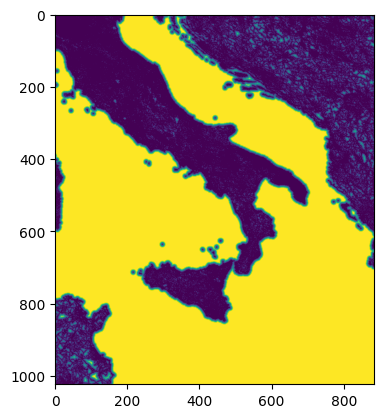

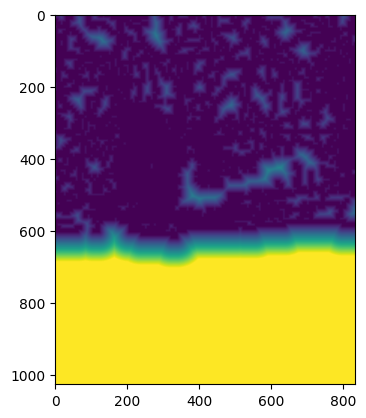

<Axes: >

In [6]:
# e.g. Italy
arr, bbox = manager.preview(get_roads_dist_meters, bounds=(10, 35, 20, 45))
show(arr)

# e.g. Lagos
arr, bbox = manager.preview(get_roads_dist_meters, bounds=(3, 6, 4, 7))
show(arr)

## Executing analysis in chunks

If we're satisfied with our analysis, the next step is to set up the full run.

We'll use the `cog_worker.Manager` to chunk our analysis into chunks of 4096x4096 px.

When dividing the analysis into chunks, we need to account for roads that might be outside the tile.
We can do this by setting the `buffer` relative to the scale of our analysis, and the maximum distance that we care about.
The worker will read `buffer` extra pixels outside of its bounds, make them available for computation, 
and then discard them before saving the results.

In [7]:
max_dist = 10000  # meters
scale = 1000  # meters
buffer = int(max_dist / scale)  # pixels

manager = Manager(
    bounds = (-180, -90, 180, 90),
    proj = "+proj=moll",
    scale = scale,
    buffer = buffer
)

<Axes: >

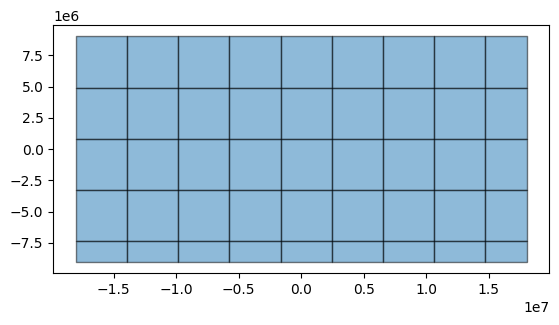

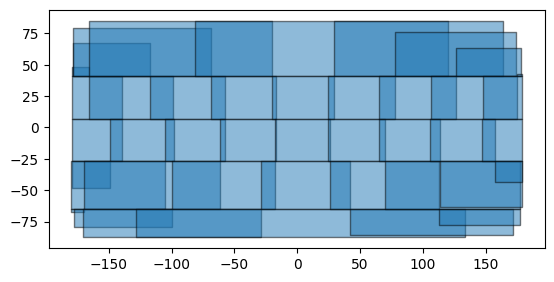

In [8]:
# we can preview how the manager will divide the world
import geopandas
from shapely import geometry

bboxes = [
    geometry.box(*bbox) 
    for bbox in manager.chunks(chunksize=4096)
]

# Chunks in projected coordinates
geopandas.GeoDataFrame(geometry=bboxes).plot(alpha=0.5, edgecolor='000')

bboxes_lnglat = [
    geometry.box(*manager.proj.transform_bounds(*bbox, direction='inverse'))
    for bbox in manager.chunks(chunksize=4096)
]

# Chunks in lat-lng coordinates
geopandas.GeoDataFrame(geometry=bboxes_lnglat).plot(alpha=0.5, edgecolor='000')

Finally, execute the full analysis in 4096x4096 chunks saving the results to output.tif

In [9]:
# this might take a while...
#manager.chunk_save('output.tif', get_roads_dist_meters, chunksize=4096)

This will compute each chunk one after the other. Numpy natively parallelizes array operations, if you need to scale up to run your analysis in a larger cluster, see: [cog_worker.distributed](../cog_worker/3. distributed.rst).